In [1]:
%%shell
git clone https://github.com/pushkar-khetrapal/realtime_panoptic.git

Cloning into 'realtime_panoptic'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 66 (delta 17), reused 49 (delta 10), pack-reused 0
Unpacking objects: 100% (66/66), done.


In [2]:
!wget https://wallup.net/wp-content/uploads/2016/01/256862-car-landscape-vehicle-road.jpg

--2020-08-17 11:23:27--  https://wallup.net/wp-content/uploads/2016/01/256862-car-landscape-vehicle-road.jpg
Resolving wallup.net (wallup.net)... 104.24.117.237, 172.67.163.163, 104.24.116.237, ...
Connecting to wallup.net (wallup.net)|104.24.117.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpg]
Saving to: ‘256862-car-landscape-vehicle-road.jpg’

256862-car-landscap     [    <=>             ]   1.60M  1.71MB/s    in 0.9s    

2020-08-17 11:23:35 (1.71 MB/s) - ‘256862-car-landscape-vehicle-road.jpg’ saved [1675401]



In [3]:
!wget https://tri-ml-public.s3.amazonaws.com/github/realtime_panoptic/models/cvpr_realtime_pano_cityscapes_standalone_no_prefix.pth

--2020-08-17 11:23:39--  https://tri-ml-public.s3.amazonaws.com/github/realtime_panoptic/models/cvpr_realtime_pano_cityscapes_standalone_no_prefix.pth
Resolving tri-ml-public.s3.amazonaws.com (tri-ml-public.s3.amazonaws.com)... 52.216.107.228
Connecting to tri-ml-public.s3.amazonaws.com (tri-ml-public.s3.amazonaws.com)|52.216.107.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122974869 (117M) [binary/octet-stream]
Saving to: ‘cvpr_realtime_pano_cityscapes_standalone_no_prefix.pth’

cvpr_realtime_pano_ 100%[===================>] 117.28M  29.3MB/s    in 4.0s    

2020-08-17 11:23:43 (29.3 MB/s) - ‘cvpr_realtime_pano_cityscapes_standalone_no_prefix.pth’ saved [122974869/122974869]



In [4]:
%%bash 
pip uninstall -y apex
git clone https://www.github.com/nvidia/apex
cd apex
python setup.py install



torch.__version__  = 1.6.0+cu101


running install
running bdist_egg
running egg_info
creating apex.egg-info
writing apex.egg-info/PKG-INFO
writing dependency_links to apex.egg-info/dependency_links.txt
writing top-level names to apex.egg-info/top_level.txt
writing manifest file 'apex.egg-info/SOURCES.txt'
writing manifest file 'apex.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/apex
copying apex/__init__.py -> build/lib/apex
creating build/lib/apex/optimizers
copying apex/optimizers/__init__.py -> build/lib/apex/optimizers
copying apex/optimizers/fused_novograd.py -> build/lib/apex/optimizers
copying apex/optimizers/fused_adagrad.py -> build/lib/apex/optimizers
copying apex/optimizers/fused_sgd.py -> build/lib/apex/optimizers
copying apex/optimizers/fused_adam.py -> build/lib/apex/optimizers
copying apex/optimizers/fused_lamb.py -> build/lib/apex/optimizers
creat

Cloning into 'apex'...
setup.py:67: UserWarning: Option --pyprof not specified. Not installing PyProf dependencies!
  warnings.warn("Option --pyprof not specified. Not installing PyProf dependencies!")
zip_safe flag not set; analyzing archive contents...
apex.pyprof.nvtx.__pycache__.nvmarker.cpython-36: module references __file__
apex.pyprof.nvtx.__pycache__.nvmarker.cpython-36: module references __path__


In [5]:
#%%shell
#pip install future typing numpy awscli
#pip install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
#pip install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl

In [6]:
#%%shell
#pip install pillow==5.0.0

In [5]:
!pip install yacs

In [6]:
!mv '/content/realtime_panoptic/realtime_panoptic' '/usr/local/lib/python3.6/dist-packages'

In [7]:
# This script provides a demo inference a model trained on Cityscapes dataset.
import warnings
import argparse
import torch
import numpy as np
from PIL import Image
from torchvision.models.detection.image_list import ImageList

from realtime_panoptic.models.rt_pano_net import RTPanoNet
from realtime_panoptic.config import cfg
import realtime_panoptic.data.panoptic_transform as P
from realtime_panoptic.utils.visualization import visualize_segmentation_image,visualize_detection_image

In [8]:
cityscapes_colormap = np.array([
 [128,  64, 128],
 [244,  35, 232],
 [ 70,  70,  70],
 [102, 102, 156],
 [190, 153, 153],
 [153, 153, 153],
 [250 ,170,  30],
 [220, 220,   0],
 [107, 142,  35],
 [152, 251, 152],
 [ 70, 130, 180],
 [220,  20,  60],
 [255,   0,   0],
 [  0,   0, 142],
 [  0,   0,  70],
 [  0,  60, 100],
 [  0,  80, 100],
 [  0,   0, 230],
 [119,  11,  32],
 [  0,   0,   0]])

cityscapes_instance_label_name = ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']
warnings.filterwarnings("ignore", category=UserWarning)

In [9]:
cfg.merge_from_file('/content/realtime_panoptic/configs/demo_config.yaml')

In [10]:
cfg.model.backbone

'R-50-FPN-RETINANET'

In [11]:
model = RTPanoNet(
    backbone=cfg.model.backbone, 
    num_classes=cfg.model.panoptic.num_classes,
    things_num_classes=cfg.model.panoptic.num_thing_classes,
    pre_nms_thresh=cfg.model.panoptic.pre_nms_thresh,
    pre_nms_top_n=cfg.model.panoptic.pre_nms_top_n,
    nms_thresh=cfg.model.panoptic.nms_thresh,
    fpn_post_nms_top_n=cfg.model.panoptic.fpn_post_nms_top_n,
    instance_id_range=cfg.model.panoptic.instance_id_range)
device = 'cuda'
model.to(device)

RTPanoNet(
  (backbone): ResNetWithModifiedFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256)
          )
        )
        (1): Bott

In [12]:
model.load_state_dict(torch.load('/content/cvpr_realtime_pano_cityscapes_standalone_no_prefix.pth'))

<All keys matched successfully>

In [13]:
print(model)

RTPanoNet(
  (backbone): ResNetWithModifiedFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256)
          )
        )
        (1): Bott

In [14]:
# Prepare for model inference.
input_image = Image.open('/content/realtime_panoptic/media/figs/test.png')
data = {'image': input_image}
# data pre-processing
normalize_transform = P.Normalize(mean=cfg.input.pixel_mean, std=cfg.input.pixel_std, to_bgr255=cfg.input.to_bgr255)
transform = P.Compose([
    P.ToTensor(),
    normalize_transform,
])
data = transform(data)
print("Done with data preparation and model configuration.")
input_image_list = ImageList([data['image'].to(device)], image_sizes=[input_image.size[::-1]])
input = torch.stack(input_image_list.tensors)

Done with data preparation and model configuration.


In [15]:
input.shape

torch.Size([1, 3, 1024, 2048])

In [16]:
!wget 'https://storage.googleapis.com/groundai-web-prod/media%2Fusers%2Fuser_272722%2Fproject_255779%2Fimages%2Ftraining_0.jpg'

--2020-08-17 11:25:30--  https://storage.googleapis.com/groundai-web-prod/media%2Fusers%2Fuser_272722%2Fproject_255779%2Fimages%2Ftraining_0.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166289 (162K) [image/jpeg]
Saving to: ‘media%2Fusers%2Fuser_272722%2Fproject_255779%2Fimages%2Ftraining_0.jpg’

media%2Fusers%2Fuse 100%[===================>] 162.39K  --.-KB/s    in 0.001s  

2020-08-17 11:25:30 (153 MB/s) - ‘media%2Fusers%2Fuser_272722%2Fproject_255779%2Fimages%2Ftraining_0.jpg’ saved [166289/166289]



In [17]:
# Prepare for model inference.
model.eval()
input_image = Image.open('/content/media%2Fusers%2Fuser_272722%2Fproject_255779%2Fimages%2Ftraining_0.jpg')
data = {'image': input_image}
# data pre-processing
normalize_transform = P.Normalize(mean=cfg.input.pixel_mean, std=cfg.input.pixel_std, to_bgr255=cfg.input.to_bgr255)
transform = P.Compose([
    P.ToTensor(),
    normalize_transform,
])
data = transform(data)
print("Done with data preparation and model configuration.")
with torch.no_grad():
    input_image_list = ImageList([data['image'].to(device)], image_sizes=[input_image.size[::-1]])
    panoptic_result, _ = model.forward(input_image_list)
    print("Done with model inference.")
    print("Process and visualizing the outputs...")
    instance_detection = [o.to('cpu') for o in panoptic_result["instance_segmentation_result"]]
    semseg_logics = [o.to('cpu') for o in panoptic_result["semantic_segmentation_result"]]
    semseg_prob = [torch.argmax(semantic_logit , dim=0) for semantic_logit in  semseg_logics]

    seg_vis = visualize_segmentation_image(semseg_prob[0], input_image, cityscapes_colormap)
    Image.fromarray(seg_vis.astype('uint8')).save('semantic_segmentation_result.jpg')
    print("Saved semantic segmentation visualization in semantic_segmentation_result.jpg")
    det_vis = visualize_detection_image(instance_detection[0], input_image, cityscapes_instance_label_name)
    Image.fromarray(det_vis.astype('uint8')).save('instance_segmentation_result.jpg')
    print("Saved instance segmentation visualization in instance_segmentation_result.jpg")
    print("Demo finished.")

Done with data preparation and model configuration.
Done with model inference.
Process and visualizing the outputs...
Saved semantic segmentation visualization in semantic_segmentation_result.jpg
Saved instance segmentation visualization in instance_segmentation_result.jpg
Demo finished.


In [18]:
from realtime_panoptic.utils.panoptic_vis import panoptic_visualization
pan = panoptic_visualization(instance_detection[0], semseg_prob[0], input_image)

/usr/local/lib/python3.6/dist-packages/realtime_panoptic/utils/panoptic_vis.py:139: RuntimeWarning: overflow encountered in exp
  z = 1/(1 + np.exp(x))


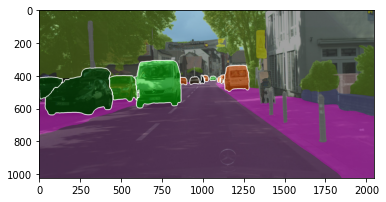

In [20]:
import matplotlib.pyplot as plt
plt.imshow(pan)

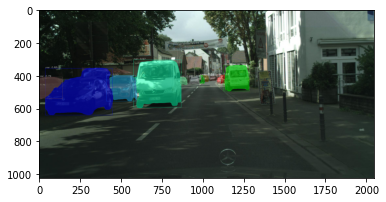

In [20]:
import matplotlib.pyplot as plt
plt.imshow(det_vis)

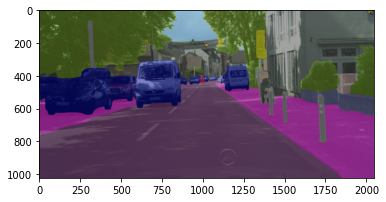

In [21]:
plt.imshow(seg_vis)

In [22]:
import copy

import cv2
import numpy as np
import torch

DETECTRON_PALETTE = np.array(
    [
        0.000, 0.447, 0.741,
        0.850, 0.325, 0.098,
        0.929, 0.694, 0.125,
        0.494, 0.184, 0.556,
        0.466, 0.674, 0.188,
        0.301, 0.745, 0.933,
        0.635, 0.078, 0.184,
        0.300, 0.300, 0.300,
        0.600, 0.600, 0.600,
        1.000, 0.000, 0.000,
        1.000, 0.500, 0.000,
        0.749, 0.749, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 1.000,
        0.667, 0.000, 1.000,
        0.333, 0.333, 0.000,
        0.333, 0.667, 0.000,
        0.333, 1.000, 0.000,
        0.667, 0.333, 0.000,
        0.667, 0.667, 0.000,
        0.667, 1.000, 0.000,
        1.000, 0.333, 0.000,
        1.000, 0.667, 0.000,
        1.000, 1.000, 0.000,
        0.000, 0.333, 0.500,
        0.000, 0.667, 0.500,
        0.000, 1.000, 0.500,
        0.333, 0.000, 0.500,
        0.333, 0.333, 0.500,
        0.333, 0.667, 0.500,
        0.333, 1.000, 0.500,
        0.667, 0.000, 0.500,
        0.667, 0.333, 0.500,
        0.667, 0.667, 0.500,
        0.667, 1.000, 0.500,
        1.000, 0.000, 0.500,
        1.000, 0.333, 0.500,
        1.000, 0.667, 0.500,
        1.000, 1.000, 0.500,
        0.000, 0.333, 1.000,
        0.000, 0.667, 1.000,
        0.000, 1.000, 1.000,
        0.333, 0.000, 1.000,
        0.333, 0.333, 1.000,
        0.333, 0.667, 1.000,
        0.333, 1.000, 1.000,
        0.667, 0.000, 1.000,
        0.667, 0.333, 1.000,
        0.667, 0.667, 1.000,
        0.667, 1.000, 1.000,
        1.000, 0.000, 1.000,
        1.000, 0.333, 1.000,
        1.000, 0.667, 1.000,
        0.167, 0.000, 0.000,
        0.333, 0.000, 0.000,
        0.500, 0.000, 0.000,
        0.667, 0.000, 0.000,
        0.833, 0.000, 0.000,
        1.000, 0.000, 0.000,
        0.000, 0.167, 0.000,
        0.000, 0.333, 0.000,
        0.000, 0.500, 0.000,
        0.000, 0.667, 0.000,
        0.000, 0.833, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 0.167,
        0.000, 0.000, 0.333,
        0.000, 0.000, 0.500,
        0.000, 0.000, 0.667,
        0.000, 0.000, 0.833,
        0.000, 0.000, 1.000,
        0.000, 0.000, 0.000,
        0.143, 0.143, 0.143,
        0.286, 0.286, 0.286,
        0.429, 0.429, 0.429,
        0.571, 0.571, 0.571,
        0.714, 0.714, 0.714,
        0.857, 0.857, 0.857,
        1.000, 1.000, 1.000
    ]
).astype(np.float32).reshape(-1, 3) * 255

In [201]:
def random_color(base, max_dist=30):
    """Generate random color close to a given base color.
    Parameters:
    -----------
    base: array_like
        Base color for random color generation
    max_dist: int
        Max distance from generated color to base color on all RGB axis.
    
    Returns:
    --------
    random_color: tuple
        3 channel random color around the given base color.
    """
    base = np.array(base)
    new_color = base + np.random.randint(low=-max_dist, high=max_dist + 1, size=3)
    return tuple(np.maximum(0, np.minimum(255, new_color)))

def draw_mask(im, mask, alpha=0.5, color=None):
    """Overlay a mask on top of the image.
    Parameters:
    -----------
    im: array_like
        A 3-channel uint8 image
    mask: array_like
        A binary 1-channel image of the same size
    color: bool
        If None, will choose automatically
    alpha: float
        mask intensity
    Returns:
    --------
    im: np.array
        Image overlaid by masks.
    color: list
        Color used for masks. 
    """
    if color is None:
        color = DETECTRON_PALETTE[np.random.choice(len(DETECTRON_PALETTE))][::-1]
    color = np.asarray(color, dtype=np.int64)
    im = np.where(np.repeat((mask > 0)[:, :, None], 3, axis=2), im * (1 - alpha) + color * alpha, im)
    im = im.astype('uint8')
    return im, color.tolist()

In [202]:
import cv2
def twotothree(x):
  z = np.concatenate((x.reshape(1024, 2048, 1),x.reshape(1024, 2048, 1),x.reshape(1024, 2048, 1)),axis=2)
  return z
def sigmoid(x):
  z = 1/(1 + np.exp(x)) 
  return z
def getBordered(image, width):
    bg = np.zeros(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)[...,0]
    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    biggest = 0
    bigcontour = None
    for contour in contours:
        area = cv2.contourArea(contour) 
        if area > biggest:
            biggest = area
            bigcontour = contour
    return cv2.drawContours(bg, [bigcontour], 0, (255, 255, 255), width).astype(bool) 
def masked_image(predictions, original_image, label_id_to_names, y_instance, fade_weight=0.8):
    """Log a single detection result for visualization.
    
    Overlays predicted classes on top of raw RGB image.
    Parameters:
    -----------
    predictions: torch.cuda.LongTensor
        Per-pixel predicted class ID's for a single input image
        Shape: (H, W)
    original_image: np.array
        HxWx3 original image. or None
    label_id_to_names: list
        list of class names for instance labels
    fade_weight: float, default: 0.8
        Visualization is fade_weight * original_image + (1 - fade_weight) * predictions
    Returns:
    -------
    visualized_image: np.array
        Visualized image with detection results.
    """

    # Load raw image using provided dataset and index
    # ``images_numpy`` has shape (H, W, 3)
    # ``images_numpy`` has shape (H, W,3)
    if not isinstance(original_image, np.ndarray):
        original_image = np.array(original_image)
    original_image_height, original_image_width,_ = original_image.shape

    # overlay_boxes
    visualized_image = copy.copy(np.array(original_image))

    labels = predictions.get_field("labels").to("cpu")
    boxes = predictions.bbox

    dtype = labels.dtype
    palette = torch.tensor([2**25 - 1, 2**15 - 1, 2**21 - 1]).to(dtype)
    colors = labels[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    masks = None
    if predictions.has_field("mask"):
        masks = predictions.get_field("mask")
    else:
        masks = [None] * len(boxes)
    # overlay_class_names_and_score
    if predictions.has_field("scores"):
        scores = predictions.get_field("scores").tolist()
    else:
        scores = [1.0] * len(boxes)
    # predicted label starts from 1 as 0 is reserved for background.
    label_names = [label_id_to_names[i-1] for i in labels.tolist()]

    text_template = "{}: {:.2f}"
    visualized_image = np.zeros(visualized_image.shape)
    edge = np.zeros(visualized_image.shape)
    for box, color, score, mask, label in zip(boxes, colors, scores, masks, label_names):
        if score < 0.5:
            continue
        box = box.to(torch.int64)
        color = random_color(color)
        color = tuple(map(int, color))
        if mask is not None:
            thresh = (mask > 0.5).cpu().numpy().astype('uint8')
            visualized_image, color = draw_mask(visualized_image, thresh)
            #visualized_image = (sigmoid(visualized_image) + sigmoid(y_instance))*(2*visualized_image)
            #visualized_image = visualized_image.astype('uint8')
            edge = edge + getBordered(twotothree(thresh), 3)


        #x, y = box[:2]
        #s = text_template.format(label, score)
        #cv2.putText(visualized_image, s, (x, y), cv2.FONT_HERSHEY_SIMPLEX, .5, (255, 255, 255), 1)
        #print(thresh.shape)
        #print(color)
        #top_left, bottom_right = box[:2].tolist(), box[2:].tolist()
        #visualized_image = cv2.rectangle(visualized_image, tuple(top_left), tuple(bottom_right), tuple(color), 1)
    return (visualized_image, edge.astype('uint8'), thresh)
x = masked_image(instance_detection[0], input_image, cityscapes_instance_label_name, y_instance)

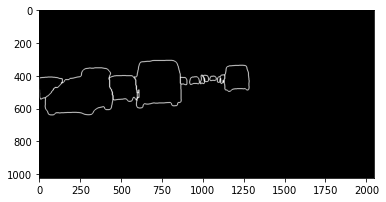

In [203]:
plt.imshow(x[1]*255, cmap='gray')

In [204]:
def seg_image(predictions, original_image, colormap, fade_weight=0.5):
    """Log a single segmentation result for visualization using a colormap.
    
    Overlays predicted classes on top of raw RGB image if given.
    Parameters:
    -----------
    predictions: torch.cuda.LongTensor
        Per-pixel predicted class ID's for a single input image
        Shape: (H, W)
    original_image: np.array
        HxWx3 original image. or None
    colormap: np.array
        (N+1)x3 array colormap,where N+1 equals to the number of classes.
    fade_weight: float, default: 0.8
        Visualization is fade_weight * original_image + (1 - fade_weight) * predictions
    Returns:
    --------
    visualized_image: np.array
        Semantic semantic visualization color coded by classes.
        The visualization will be overlaid on a the RGB image if given. 
    """

    # ``original_image`` has shape (H, W,3)
    if not isinstance(original_image, np.ndarray):
        original_image = np.array(original_image)
    original_image_height, original_image_width,_ = original_image.shape

    # Grab colormap from dataset for the given number of segmentation classes
    # (uses black for the IGNORE class)
    # ``colormap`` has shape (num_classes + 1, 3)

    # Color per-pixel predictions using the generated color map
    # ``colored_predictions_numpy`` has shape (H, W, 3)
    predictions_numpy = predictions.cpu().numpy().astype('uint8')
    colored_predictions_numpy = colormap[predictions_numpy.flatten()]
    colored_predictions_numpy = colored_predictions_numpy.reshape(original_image_height, original_image_width, 3)

    # Overlay images and predictions
    overlaid_predictions = original_image * fade_weight + colored_predictions_numpy * (1 - fade_weight)

    visualized_image = overlaid_predictions.astype('uint8')
    return visualized_image

In [205]:
cm_instance = np.array([[0,  0, 0],
                        [0,  0, 0],
                        [0,  0, 0],
                        [0,  0, 0],
                        [0,  0, 0],
                        [0,  0, 0],
                        [0,  0, 0],
                        [0,  0, 0],
                        [0,  0, 0],
                        [0,  0, 0],
                        [0,  0, 0],
                        [220,  20,  60],
                        [255,   0,   0],
                        [  0,   0, 142],
                        [  0,   0,  70],
                        [  0,  60, 100],
                        [  0,  80, 100],
                        [  0,   0, 230],
                        [119,  11,  32],
                        [  0,   0,   0]])
cm_seg = np.array([[128,  64, 128],
                  [244,  35, 232],
                  [ 70,  70,  70],
                  [102, 102, 156],
                  [190, 153, 153],
                  [153, 153, 153],
                  [250, 170,  30],
                  [220, 220,   0],
                  [107, 142,  35],
                  [152, 251, 152],
                  [ 70, 130, 180],
                  [0,  0, 0],
                  [0,  0, 0],
                  [0,  0, 0],
                  [0,  0, 0],
                  [0,  0, 0],
                  [0,  0, 0],
                  [0,  0, 0],
                  [0,  0, 0],
                  [0, 0, 0]])
LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])
cityscapes_instance_label_name = ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']
y_instance = seg_image(semseg_prob[0], input_image, cm_instance, 0)
y_seg = seg_image(semseg_prob[0], input_image, cm_seg, 0.5)
x = masked_image(instance_detection[0], input_image, cityscapes_instance_label_name)

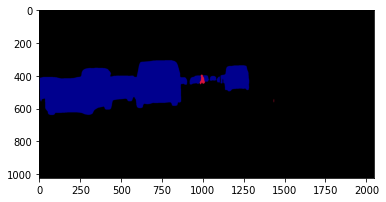

In [206]:
plt.imshow(y_instance)

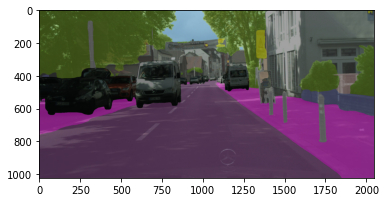

In [207]:
plt.imshow(y_seg)

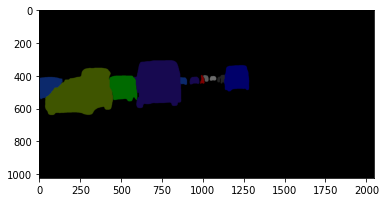

In [208]:
plt.imshow(x[0], cmap='gray')

In [209]:
def sigmoid(x):
  z = 1/(1 + np.exp(x)) 
  return z
s = (sigmoid(x[0]) + sigmoid(y_instance))*(2*x[0])
s = s.astype('uint8')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


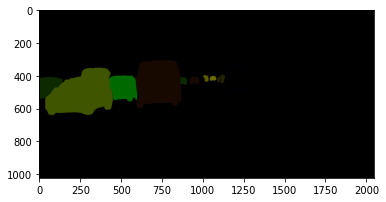

In [210]:
plt.imshow(s, cmap='gray')

In [216]:
# Range for lower red
lower_red = np.array([55, 55, 55])
upper_red = np.array([255, 255, 255])
mask1 = cv2.inRange(x[1]*255, lower_red, upper_red)
mask1 = cv2.bitwise_not(mask1)

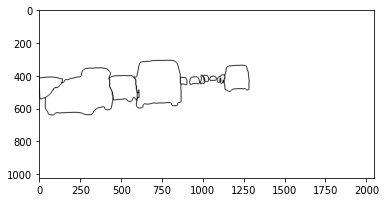

In [217]:
plt.imshow(mask1*255, cmap='gray')

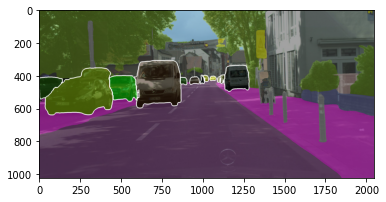

In [225]:
pan = (s + y_seg)*twotothree(mask1*255) + x[1]*255
Image.fromarray(pan.astype('uint8')).save('panoptic_segmentation_result.jpg')
plt.imshow(pan)

In [ ]:
visualized_image = np.zeros(x.shape)

In [ ]:
x = masked_image(instance_detection[0], input_image, cityscapes_instance_label_name, y_instance)

BoxList(num_boxes=66, image_width=2048, image_height=1024, mode=xyxy)

In [ ]:
def panoptic(input_image):
  # Prepare for model inference.
  model.eval()
  data = {'image': input_image}
  # data pre-processing
  normalize_transform = P.Normalize(mean=cfg.input.pixel_mean, std=cfg.input.pixel_std, to_bgr255=cfg.input.to_bgr255)
  transform = P.Compose([
      P.ToTensor(),
      normalize_transform,
  ])
  data = transform(data)
  #print("Done with data preparation and model configuration.")
  with torch.no_grad():
      input_image_list = ImageList([data['image'].to(device)], image_sizes=[input_image.size[::-1]])
      panoptic_result, _ = model.forward(input_image_list)
      #print("Done with model inference.")
      #print("Process and visualizing the outputs...")
      instance_detection = [o.to('cpu') for o in panoptic_result["instance_segmentation_result"]]
      semseg_logics = [o.to('cpu') for o in panoptic_result["semantic_segmentation_result"]]
      semseg_prob = [torch.argmax(semantic_logit , dim=0) for semantic_logit in  semseg_logics]
      seg_vis = visualize_segmentation_image(semseg_prob[0], input_image, cityscapes_colormap)
      #print("Saved semantic segmentation visualization in semantic_segmentation_result.jpg")
      det_vis = visualize_detection_image(instance_detection[0], input_image, cityscapes_instance_label_name)
      #Image.fromarray(det_vis.astype('uint8')).save('instance_segmentation_result.jpg')
      #print("Saved instance segmentation visualization in instance_segmentation_result.jpg")
      #print("Demo finished.")
      return seg_vis

In [ ]:
import cv2
from PIL import Image
frame = cv2.imread('/content/realtime_panoptic/media/figs/test.png')
frame = Image.fromarray(np.uint8(frame)).convert('RGB')
z = panoptic(frame) 
Image.fromarray(z.astype('uint8')).save("/content/{}.jpg".format(1))

In [ ]:
!wget http://s150102174.onlinehome.fr/Lara/files/Lara_UrbanSeq1_MPEG2.mpg

--2020-08-05 21:08:54--  http://s150102174.onlinehome.fr/Lara/files/Lara_UrbanSeq1_MPEG2.mpg
Resolving s150102174.onlinehome.fr (s150102174.onlinehome.fr)... 217.160.0.161
Connecting to s150102174.onlinehome.fr (s150102174.onlinehome.fr)|217.160.0.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208220164 (199M) [video/mpeg]
Saving to: ‘Lara_UrbanSeq1_MPEG2.mpg’

Lara_UrbanSeq1_MPEG 100%[===================>] 198.57M  6.92MB/s    in 29s     

2020-08-05 21:09:24 (6.78 MB/s) - ‘Lara_UrbanSeq1_MPEG2.mpg’ saved [208220164/208220164]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import cv2 
from PIL import Image
import time

video = cv2.VideoCapture('/content/Lara_UrbanSeq1_MPEG2.mpg')
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# We need to check if camera 
# is opened previously or not 
if (video.isOpened() == False): 
	print("Error reading video file") 

# We need to set resolutions. 
size = (width, height) 

count = 1
# Below VideoWriter object will create 
# a frame of above defined The output 
# is stored in 'filename.avi' file. 
start_time = time.time()
while(True): 
  ret, frame = video.read()
  print(count)
  if ret == True:
    frame = Image.fromarray(np.uint8(frame)).convert('RGB')

    z = panoptic(frame) 
    Image.fromarray(z.astype('uint8')).save("/content/drive/My Drive/DrivingImages/{}.jpg".format(count))
      
    count = count + 1
    #cv2_imshow(detr(frame))
    # Break the loop 

  else:
    break

# When everything done, release 
# the video capture and video 
# write objects 
video.release() 

# Closes all the frames 
cv2.destroyAllWindows() 

print("The video was successfully saved") 
print("--- %s seconds ---" % (time.time() - start_time))
t = time.time() - start_time

In [ ]:
11169/t

6.115676812987131

In [ ]:
import os
import moviepy.video.io.ImageSequenceClip
image_folder='/content/drive/My Drive/DrivingImages'
fps=30

image_files = [image_folder+'/'+img for img in os.listdir(image_folder) if img.endswith(".jpg")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('/content/drive/My Drive/myVideo.mp4')

[MoviePy] >>>> Building video /content/drive/My Drive/myVideo.mp4
[MoviePy] Writing video /content/drive/My Drive/myVideo.mp4


100%|██████████| 11169/11169 [05:14<00:00, 35.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/My Drive/myVideo.mp4 



In [ ]:
model

RTPanoNet(
  (backbone): ResNetWithModifiedFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
        (1): Bottleneck(
          (con

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())

In [ ]:
pytorch_total_params

30624107

4